In [1]:
%load_ext autoreload
%autoreload 2
from dataset import prepare, assemble
import regressor
import utils
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Conv2D, Flatten
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [57]:

def build_model():
    md = Sequential()
    md.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=regressor.INPUT_SHAPE))
    md.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
    md.add(Flatten())
    md.add(Dense(32, activation='relu'))
    md.add(Dense(1, activation='relu'))
    md.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return md

def build_model2():
    nb_filters = 8
    model = Sequential()
    model.add(Conv2D(filters=nb_filters, kernel_size=5, activation='relu', input_shape=regressor.INPUT_SHAPE))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error', optimizer='Adadelta', metrics=['mae'])
    return model

def test_data():
    regressor.INPUT_SHAPE = (128, 128, 3)
    df = pd.read_csv('/data/staff/common/ML-crystals/fakeset/fake.csv')
    # zero_y = df[df['y']==0]
    # df = df.drop(zero_y.sample(frac=0.5).index)
    print(len(df))

    f_sample = lambda f: Path(f).parts[7:8][0]
    samples = set(df['filename'].map(f_sample))
    train, test = train_test_split(list(samples), test_size=0.4, random_state=42)
    valid, test = train_test_split(list(samples - set(train)), test_size=0.5, random_state=42)

    train_idx = df['filename'].map(f_sample).isin(train)
    test_idx = df['filename'].map(f_sample).isin(test)
    valid_idx = df['filename'].map(f_sample).isin(valid)
    f_load_img = lambda f: np.stack(cv.imread(f))
    train_x, train_y = df[train_idx]['filename'].map(f_load_img), df[train_idx]['y'].values
    test_x, test_y = df[test_idx]['filename'].map(f_load_img), df[test_idx]['y'].values
    valid_x, valid_y = df[valid_idx]['filename'].map(f_load_img), df[valid_idx]['y'].values

    train_x = np.stack(train_x).reshape(len(train_x), *regressor.INPUT_SHAPE)
    test_x = np.stack(test_x).reshape(len(test_x), *regressor.INPUT_SHAPE)
    valid_x = np.stack(valid_x).reshape(len(valid_x), *regressor.INPUT_SHAPE)
    model = build_model2()
    model.fit(train_x, train_y, epochs=3, batch_size=64, validation_data=(valid_x, valid_y))
    score = model.evaluate(test_x, test_y, batch_size=64)
    print(score)
    return model
    
def vali():
    res = model.predict(valid_x, batch_size=64, verbose=1)
    max_sort = np.argsort(res, axis=0)[::-1]
    print(len(max_sort))
    i = 500
    plt.imshow(valid_x[max_sort[i]].reshape((128, 128, 3)))
    plt.title(res[max_sort[i]][0]);
    
model = test_data()

10000
Train on 5921 samples, validate on 2017 samples
Epoch 1/3
5921/5921 [==============================] - 7s 1ms/step - loss: 6.6056 - mean_absolute_error: 1.0441 - val_loss: 1.8799 - val_mean_absolute_error: 0.5541
Epoch 2/3
5921/5921 [==============================] - 5s 900us/step - loss: 2.6204 - mean_absolute_error: 0.6171 - val_loss: 3.1516 - val_mean_absolute_error: 0.6858
Epoch 3/3
2062/2062 [==============================] - 0s 239us/step
[0.452934703022733, 0.28655764911500836]


In [29]:
regressor.INPUT_SHAPE = (128, 128, 1)
df = assemble.get_dataset_df('/data/staff/common/ML-crystals/csv/test0.5.csv')
df.head()
print(len(df))
df = df.drop(df[df['y'] < 200].sample(frac=0.8).index)
df.head(n=100)

loading meta files
meta loaded
11690


,filename,y,sample,scan,zoom
2,/data/visitors/biomax/20180479/20181214/raw/Sa...,41,Sample-3-09,20180479_1,8
3,/data/visitors/biomax/20180479/20181214/raw/Sa...,42,Sample-3-09,20180479_1,8
5,/data/visitors/biomax/20180479/20181214/raw/Sa...,40,Sample-3-09,20180479_1,8
12,/data/visitors/biomax/20180479/20181214/raw/Sa...,52,Sample-3-09,20180479_1,8
16,/data/visitors/biomax/20180479/20181214/raw/Sa...,41,Sample-3-09,20180479_1,8
21,/data/visitors/biomax/20180479/20181214/raw/Sa...,29,Sample-3-09,20180479_1,8
22,/data/visitors/biomax/20180479/20181214/raw/Sa...,25,Sample-3-09,20180479_1,8
24,/data/visitors/biomax/20180479/20181214/raw/Sa...,36,Sample-3-09,20180479_1,8
36,/data/visitors/biomax/20180479/20181214/raw/Sa...,121,Sample-3-09,20180479_1,8
43,/data/visitors/biomax/20180479/20181214/raw/Sa...,73,Sample-3-09,20180479_1,8


In [31]:
train, valid, test = assemble.get_dataset(df, regressor.INPUT_SHAPE)

  0%|          | 18/6344 [00:00<00:35, 178.90it/s]

row mapping row_pipeline


  2%|▏         | 110/6344 [00:00<00:05, 1095.10it/s]

row mapping relit_img


  5%|▌         | 343/6344 [00:00<00:01, 3423.13it/s]

row mapping normed_img


 11%|█         | 706/6344 [00:00<00:00, 7054.93it/s]

Y normalization
flip augmentation


100%|██████████| 6344/6344 [00:00<00:00, 7708.17it/s]


In [32]:
model = build_model2()
model.fit(train['x'], train['y'], epochs=5, batch_size=32, validation_data=(valid['x'], valid['y']))
score = model.evaluate(test['x'], test['y'], batch_size=32)

Train on 7078 samples, validate on 4214 samples
Epoch 1/5
7078/7078 [==============================] - 9s 1ms/step - loss: 0.3487 - mean_absolute_error: 0.4530 - val_loss: 0.0220 - val_mean_absolute_error: 0.1483
Epoch 2/5
7078/7078 [==============================] - 9s 1ms/step - loss: 0.1013 - mean_absolute_error: 0.2550 - val_loss: 0.0599 - val_mean_absolute_error: 0.2448
Epoch 3/5
7078/7078 [==============================] - 9s 1ms/step - loss: 0.0469 - mean_absolute_error: 0.1727 - val_loss: 9.0954e-04 - val_mean_absolute_error: 0.0301
Epoch 4/5
7078/7078 [==============================] - 9s 1ms/step - loss: 0.0332 - mean_absolute_error: 0.1459 - val_loss: 5.8917e-04 - val_mean_absolute_error: 0.0242
Epoch 5/5
1396/1396 [==============================] - 0s 282us/step


In [38]:
res = model.predict(valid['x'], batch_size=64, verbose=1)

4214/4214 [==============================] - 1s 223us/step


In [39]:
print(np.max(res))
print(np.min(res))

-1.6611204
-1.6611675


-0.8685514
5948


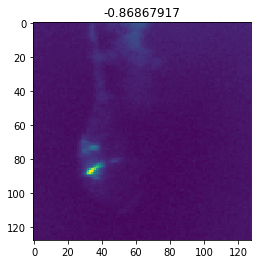

In [16]:
max_sort = np.argsort(res)
print(np.max(res))
print(len(max_sort))
i = 0
plt.imshow(valid['x'][max_sort[i]].reshape((regressor.INPUT_SHAPE[:-1])))
plt.title(res[max_sort[i]]);